# Simple speech recognition

Audio 데이터를 다뤄서 학습하는 방법을 배워보도록 합시다.
머신러닝 작업과정은 아래와 같습니다.

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

* 모델 완성 후 평가 지표에 따라서 모델을 평가해 봅시다.
* tensorflow 2.1 버전에 최적화되어있습니다.

## Project 설명
### Task
* 1초 길이의 오디오 음성데이터를 이용해 단어를 분류하는 것이 목표입니다.
* 주어진 데이터를 이용해 딥러닝 트레이닝 과정을 구현해 보는것이 목표입니다.
* This code is borrowed from [Kaggle/TensorFlow Speech Recognition Challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge).
* This is version 0.01 of the data set containing 64,727 audio files, released on August 3rd 2017.

### Baseline
* 기본적으로 사용하는 Convulution layers를 구성해 사용해보자.
    * ex) Conv - Conv - pooling - FC layers
* 오버피팅을 방지하기 위한 다양한 방법들을 사용해보자.
* Training
    * tf.data.dataset과 model.fit()을 사용
* Evaluation
    * 모델의 정확도와 크기를 이용해 점수를 제공하는 메트릭으로 평가해보자.

### Setting tensorflow version

In [1]:
#!pip install tensorflow-gpu==2.1

### Import packages

* 우리가 사용할 packages 를 import 하는 부분 입니다.
* 필요에 따른 packages를 선언합니다.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, ReLU,Activation
from tensorflow.keras.models import Sequential
import librosa
import librosa.display
import matplotlib.pyplot as plt

import os
from os.path import isdir, join

import random
import copy

tf.__version__

'2.1.0'

## Import modules

### Import colab modules for Google Colab (if necessary)

### Checking dataset

In [3]:
speech_data = np.load("content/datasets/speech_wav_8000.npz")

In [4]:
speech_data["wav_vals"].shape

(50620, 8000)

In [5]:
test_wav = speech_data["wav_vals"][0]

In [6]:
test_wav.shape

(8000,)

### Wave to spectrogram
* STFT를 이용해서 wave 형태의 데이터를 spectrogram으로 만들어준다.

In [7]:
def wav2spec(wav, fft_size=258):
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [8]:
spec = wav2spec(test_wav)

In [9]:
spec.shape

(130, 126)

In [10]:
spec.shape[0]

130

* Spectrogram으로 변환한 데이터를 plot 해본다.

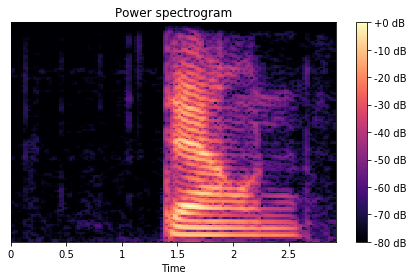

In [11]:
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

* 전체 데이터셋의 wave 데이터를 spectrogram으로 변환한다.

In [12]:
temp = []
for v in speech_data["wav_vals"]:
    wav = v
    stft = wav2spec(wav)
    temp.append(stft)
data_wav = np.array(temp)

In [13]:
data_wav.shape

(50620, 130, 126)

In [14]:
speech_data["wav_vals"].shape

(50620, 8000)

### Model dataset setting
* 변환된 데이터를 이용해서 학습에 활용할 데이터셋을 설정한다.

In [15]:
train_wav, test_wav, train_label, test_label = train_test_split(data_wav, speech_data["label_vals"], 
                                                                test_size=0.1, 
                                                                random_state = 1993)

train_wav = train_wav.reshape(-1, 130, 126, 1)
test_wav = test_wav.reshape(-1, 130, 126, 1)

print(train_wav.shape)
print(test_wav.shape)
print(train_label.shape)
print(test_label.shape)

(45558, 130, 126, 1)
(5062, 130, 126, 1)
(45558, 1)
(5062, 1)


### Target_list 설정

In [16]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

In [17]:
temp = []
for v in train_label:
    temp.append(label_value[v[0]])
train_label = np.array(temp)

temp = []
for v in test_label:
    temp.append(label_value[v[0]])
test_label = np.array(temp)

In [18]:
print('Train_Wav Demension : ' + str(np.shape(train_wav)))
print('Train_Label Demension : ' + str(np.shape(train_label)))
print('Test_Wav Demension : ' + str(np.shape(test_wav)))
print('Test_Label Demension : ' + str(np.shape(test_label)))
print('Number Of Labels : ' + str(len(label_value)))

Train_Wav Demension : (45558, 130, 126, 1)
Train_Label Demension : (45558,)
Test_Wav Demension : (5062, 130, 126, 1)
Test_Label Demension : (5062,)
Number Of Labels : 12


### Hyper-parameter setting

In [19]:
batch_size = 100
max_epochs = 20

# the save point

checkpoint_dir ='train_ckpt/spectrogram/exp8'
if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
os.path.isdir(checkpoint_dir)

True

## tf.data.dataset Setting

In [20]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [21]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


## Model 구현


In [22]:
# inputs = layers.Input(shape=(130, 126, 1))

# x = Conv2D(64,(3,3),padding="same",kernel_initializer='he_normal')(inputs)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# # x = Conv2D(64,(3,3),padding="same",kernel_initializer='he_normal')(x)
# # x = BatchNormalization()(x)
# # x = Activation('relu')(x)
# # x = MaxPooling2D((2,2))(x)
# # x = Dropout(0.2)(x)
# x = Conv2D(128,(3,3),padding="same",kernel_initializer='he_normal')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# # x = Conv2D(128,(3,3),padding="same",kernel_initializer='he_normal')(x)
# # x = BatchNormalization()(x)
# # x = Activation('relu')(x)
# x = MaxPooling2D()(x)
# # x = Dropout(0.2)(x)
# x = Conv2D(256,(3,3),padding="same",kernel_initializer='he_normal')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# # x = Conv2D(256,(3,3),padding="same",kernel_initializer='he_normal')(x)
# # x = BatchNormalization()(x)
# # x = Activation('relu')(x)
# # x = Conv2D(256,(3,3),padding="same",kernel_initializer='he_normal')(x)
# # x = BatchNormalization()(x)
# # x = Activation('relu')(x)
# x = MaxPooling2D()(x)
# # x = Dropout(0.2)(x)
# x = Conv2D(512,(3,3),padding="same",kernel_initializer='he_normal')(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# # x = Conv2D(512,(3,3),padding="same",kernel_initializer='he_normal')(x)
# # x = BatchNormalization()(x)
# # x = Activation('relu')(x)
# # x = Conv2D(512,(3,3),padding="same",kernel_initializer='he_normal')(x)
# # x = BatchNormalization()(x)
# # x = Activation('relu')(x)
# x = MaxPooling2D()(x)
# # x = Dropout(0.2)(x)
# # x = Conv2D(512,(3,3),padding="same",kernel_initializer='he_normal')(x)
# # x = BatchNormalization()(x)
# # x = Activation('relu')(x)
# # x = Conv2D(512,(3,3),padding="same",kernel_initializer='he_normal')(x)
# # x = BatchNormalization()(x)
# # x = Activation('relu')(x)
# # x = Conv2D(512,(3,3),padding="same",kernel_initializer='he_normal')(x)
# # x = BatchNormalization()(x)
# # x = Activation('relu')(x)
# # x = MaxPooling2D()(x)
# # x = Dropout(0.2)(x)
# x = layers.Flatten()(x)
# x = layers.Dense(64,activation='relu',kernel_initializer='he_normal')(x)
# outputs = layers.Dense(12,activation='softmax')(x)

# model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [29]:
model = tf.keras.Sequential([
    Conv2D(64,(3,3),padding="same",input_shape=(130,126,1),kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64,(3,3),padding="same",kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.5),
    Conv2D(128,(3,3),padding="same",kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128,(3,3),padding="same",kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.5),
    Conv2D(256,(3,3),padding="same",kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256,(3,3),padding="same",kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256,(3,3),padding="same",kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.5),
    Conv2D(512,(3,3),padding="same",kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512,(3,3),padding="same",kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512,(3,3),padding="same",kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Dropout(0.5),
    Conv2D(512,(3,3),padding="same",kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512,(3,3),padding="same",kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512,(3,3),padding="same",kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64,kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.1),
    Dense(12),
    BatchNormalization(),
    Activation('softmax'),
])

In [30]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=tf.keras.losses.categorical_crossentropy,
             optimizer=optimizer,
             metrics=['accuracy'])

### 구성된 모델 확인

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 130, 126, 64)      640       
_________________________________________________________________
batch_normalization_15 (Batc (None, 130, 126, 64)      256       
_________________________________________________________________
activation_15 (Activation)   (None, 130, 126, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 130, 126, 64)      36928     
_________________________________________________________________
batch_normalization_16 (Batc (None, 130, 126, 64)      256       
_________________________________________________________________
activation_16 (Activation)   (None, 130, 126, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 65, 63, 64)       

### 모델 콜백

In [32]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [33]:
def scheduler(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

## 모델 학습

In [28]:
# using `tf.data.Dataset`
history = model.fit(train_dataset,
                    epochs=max_epochs,
                    steps_per_epoch=train_wav.shape[0]/batch_size,
                    validation_data=test_dataset,
                    validation_steps=test_wav.shape[0]/batch_size,
                    callbacks=[lr_callback,cp_callback]
                    )

ValueError: in converted code:

    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/training_v2.py:677 map_fn
        batch_size=None)
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/training.py:2428 _standardize_tensors
        exception_prefix='input')
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow_core/python/keras/engine/training_utils.py:582 standardize_input_data
        str(data_shape))

    ValueError: Error when checking input: expected conv2d_input to have shape (130, 126, 3) but got array with shape (130, 126, 1)


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation
* Test dataset을 이용해서 모델의 성능을 평가합니다.

In [ ]:
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
results = model.evaluate(test_dataset)